In [17]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

from pandas_helper import broadcast_simple
#from fancy_plots import *

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

%matplotlib inline
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 15}
plt.rc('font', **font)


In [19]:
def u(c_,eta,offset=0):
           
    c=c_+offset
    y=(c**(1-eta)-1)/(1-eta)
    
    cond = (eta==1)
    y[cond] = np.log(c[cond]) 
    
    return y


def u_recip(u,eta, offset=0):
    c = ((1-eta)*u+1)**(1/(1-eta))
    
    cond = (eta==1)
    c[cond]==np.exp(u[cond])
    
    return c-offset
    


#if-then model
def compute_uexp(df,offset=0):
    df=df.copy()
    
    df["c_good"]= df.A*df["k"]**(df.alpha) - df.r*df.k
    df["c_bad"] = df.A*df["k"]**(df.alpha) - df.r*df.k - df.v*df.k

    df["u_good"] = u(df.c_good,df.eta, offset=offset)
    df["u_bad"] =  u(df.c_bad,df.eta, offset=offset)

    df["u_exp"] = df.p*df.u_bad + (1-df.p)*df.u_good
  
    df["c_equi"]=u_recip(df.u_exp,df.eta,offset=offset)    
    
    return df


def wraper_for_opt(x,df):
    if x<1e-5:
        return 1e5
    return -compute_uexp(df.assign(k=x)).u_exp.values[0]
  

In [4]:
#init
n=12
df=pd.DataFrame()

#parameters

#probability (with a thiner mesh close to 0)
y=(np.exp(np.linspace(0.0001,1,n))-1)
y=y/y[-1]*14/100 
y=np.append(y,0.1)
y.sort()
df["p"]=y
df["v"]=.25
df["alpha"]=0.33
df["A"]=10
df["kopt"]=np.nan
df["r"]=4/100
df["eta"]=.5

#print (df)

#replicates df with eta and r values
df=broadcast_simple(df.drop("eta",axis=1), pd.Index([0.5, 0, 1.5], name="eta" )).reset_index("eta")
df=broadcast_simple(df.drop("r",axis=1), pd.Index([0.04, 0.08, .12], name="r" )).reset_index("r")
df=df.reset_index(drop=True)

df=df.sort_values(by="p", ascending=False).sort_values(by=["eta","r"]) # smart ordering for the solver
print (df)
df.head()

        r  eta         p     v  alpha   A  kopt
108  0.04  0.0  0.140000  0.25   0.33  10   NaN
99   0.04  0.0  0.120756  0.25   0.33  10   NaN
90   0.04  0.0  0.103183  0.25   0.33  10   NaN
81   0.04  0.0  0.100000  0.25   0.33  10   NaN
72   0.04  0.0  0.087138  0.25   0.33  10   NaN
63   0.04  0.0  0.072487  0.25   0.33  10   NaN
54   0.04  0.0  0.059109  0.25   0.33  10   NaN
45   0.04  0.0  0.046893  0.25   0.33  10   NaN
36   0.04  0.0  0.035739  0.25   0.33  10   NaN
27   0.04  0.0  0.025554  0.25   0.33  10   NaN
18   0.04  0.0  0.016254  0.25   0.33  10   NaN
9    0.04  0.0  0.007762  0.25   0.33  10   NaN
0    0.04  0.0  0.000008  0.25   0.33  10   NaN
111  0.08  0.0  0.140000  0.25   0.33  10   NaN
102  0.08  0.0  0.120756  0.25   0.33  10   NaN
93   0.08  0.0  0.103183  0.25   0.33  10   NaN
84   0.08  0.0  0.100000  0.25   0.33  10   NaN
75   0.08  0.0  0.087138  0.25   0.33  10   NaN
66   0.08  0.0  0.072487  0.25   0.33  10   NaN
57   0.08  0.0  0.059109  0.25   0.33  1

,r,eta,p,v,alpha,A,kopt
108,0.04,0.0,0.140000,0.25,0.33,10,NaN
99,0.04,0.0,0.120756,0.25,0.33,10,NaN
90,0.04,0.0,0.103183,0.25,0.33,10,NaN
81,0.04,0.0,0.100000,0.25,0.33,10,NaN
72,0.04,0.0,0.087138,0.25,0.33,10,NaN


In [5]:
minimize(wraper_for_opt,83,args=(df.iloc[[0]].assign( eta=0, r=4/100, p=14/100,)))

      fun: -42.20525460180791
 hess_inv: array([[ 5522.2406466]])
      jac: array([ -9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 8
     njev: 12
   status: 0
  success: True
        x: array([ 283.73091108])

In [6]:
x_opt_guesses = pd.read_csv("xopt_guesses.csv", index_col=["eta","r"], squeeze=True)
x_opt_guesses

eta  r   
0.0  0.12      3.9
     0.04      3.1
     0.08      3.9
0.5  0.12     82.0
     0.04    160.0
     0.08    115.0
1.5  0.12     70.0
     0.04    110.0
     0.08     85.0
Name: 0, dtype: float64

In [24]:

def solve_line_by_line(df, xopt=4):
    df=df.copy()
    for idx in df.index:
        if not np.isnan(df.ix[idx,"kopt"]):
            print("skiping "+str(df.ix[idx,["r","eta","p"]].to_dict())+" as already done")
            continue
        solution = minimize(wraper_for_opt,xopt,args=(df.ix[[idx]]))
        if solution.success:
            xopt=solution.x[0]
            df.ix[idx,"kopt"]= xopt
        else:
            print("no solution for ", df.ix[idx,["eta","r","p"]].to_dict())
    return df        

df_full = df.copy().assign(k_opt_index=np.nan)

for eta in df.eta.unique():
    for r in df.r.unique():
        df_sol = solve_line_by_line(df.query("eta=={eta} & r=={r}".format(eta=eta,r=r)).sort_values(by="p", ascending=False), xopt=90)
        df_full.update(df_sol)        
df_full.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


no solution for  {'eta': 0.5, 'r': 0.040000000000000001, 'p': 0.0077622078725853609}
no solution for  {'eta': 0.5, 'r': 0.040000000000000001, 'p': 8.1480812934487002e-06}


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


no solution for  {'eta': 0.5, 'r': 0.080000000000000002, 'p': 0.0077622078725853609}
no solution for  {'eta': 0.5, 'r': 0.080000000000000002, 'p': 8.1480812934487002e-06}


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


no solution for  {'eta': 0.5, 'r': 0.12, 'p': 8.1480812934487002e-06}


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


no solution for  {'eta': 1.5, 'r': 0.040000000000000001, 'p': 8.1480812934487002e-06}


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


no solution for  {'eta': 1.5, 'r': 0.080000000000000002, 'p': 8.1480812934487002e-06}


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


,r,eta,p,v,alpha,A,kopt,k_opt_index
108,0.04,0.0,0.140000,0.25,0.33,10.0,283.738839,NaN
99,0.04,0.0,0.120756,0.25,0.33,10.0,313.244899,NaN
90,0.04,0.0,0.103183,0.25,0.33,10.0,344.953567,NaN
81,0.04,0.0,0.100000,0.25,0.33,10.0,351.250075,NaN
72,0.04,0.0,0.087138,0.25,0.33,10.0,378.916638,NaN


In [25]:
df_full["kopt"] = df_full["k"]
df_full= compute_uexp(df_full)
df_full.head()

KeyError: 'k'

In [13]:

ref_proba=1/10

df_full["c_equi_index"]=np.nan
for eta in df.eta.unique():
    for r in df.r.unique():
        df_sol = df_full.query("eta=={eta} & r=={r}".format(eta=eta,r=r)).copy()
        ref_value=df_sol.set_index("p").ix[ref_proba,"kopt"]
        df_sol["k_opt_index"] = 100*df_sol["kopt"]/ref_value
        df_full.update(df_sol[["k_opt_index"] ])
        
        ref_value=df_sol.set_index("p").ix[ref_proba,"c_equi"]
        df_sol["c_equi_index"] = 100*df_sol["c_equi"]/ref_value
        df_full.update(df_sol[["c_equi_index"] ])
        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


KeyError: 'c_equi'

In [14]:
df_full.columns

Index(['r', 'eta', 'p', 'v', 'alpha', 'A', 'kopt', 'k_opt_index',
       'c_equi_index'],
      dtype='object')

NameError: name 'spine_and_ticks' is not defined

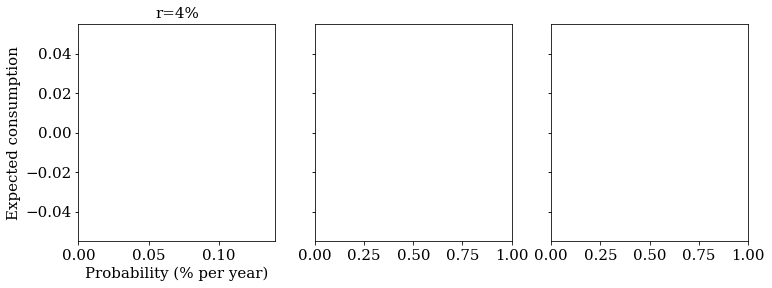

In [16]:
df_full=df_full.sort_values(by=["p"]) # smart ordering for the solver

fig, axarr = plt.subplots(1,3, figsize=(12,4) , sharey=True)

l=0

for r_fig in df.r.unique():
        for eta_fig,col in zip([1.5,0.5,0],[ "red","green","blue"] ):

#         for eta_fig,col in zip([1.5,0.5,0],[ "#377eb8","#4daf4a","#984ea3"] ):

                cond = "eta=={eta} & r=={r}".format(eta=eta_fig,r=r_fig)
                df_full.query(cond).plot(x="p",y="c_equi_index", ax=axarr[l],color=col, linewidth=2)

#         df_full.query(cond).plot(x="p",y="k_opt_index", ax=axarr[l] ,color="violet", linewidth=2)
#         ddiv2.query(cond).plot(x="p",y="W1_rel",style="--", ax=axarr[l]  ,color="black",  linewidth=2)
        
        #cond2 = "(r==r_fig)&(eta==eta_fig)&(insu==0.5)&(v==0.25)"
        #ddiv2.query(cond2).plot(x="proba",y="Wopt_rel", ax=axarr[k])
        #cond3 = "(r==r_fig)&(eta==eta_fig)&(insu==0)&(v==0.125)"
        #ddiv2.query(cond3).plot(x="proba",y="Wopt_rel", ax=axarr[k])
        axarr[l].legend_.remove()
#         axarr[l].set_ylim(ymin=60,ymax=200)        
        axarr[l].set_title("r={r:.0%}".format(r=r_fig), **font)
        axarr[l].set_xlabel("Probability (% per year)")
        axarr[l].set_ylabel("Expected consumption")
        
#         axarr[l].vlines(x=2,
#                         ymin=100,linestyles ="dotted",
#                         ymax=ddiv2.query("(r==r_fig)&(eta==1.5)&(insu==0)&(v==0.25)&(proba==2)").Wopt_rel.mean(),
#                         color="#cccccc")
                           
#         axarr[l].hlines(xmin=2,
#                         xmax=10,
#                         y=100,linestyles ="dotted",
#                         color="#cccccc")                   
                           
        spine_and_ticks(axarr[l])

        l += 1

        


axarr[0].legend(["Investment response (High risk aversion, $\eta=1.5$)", 
                 "Investment response (Low risk aversion, $\eta=0.5$)",
                "Investment response (No risk aversion, $\eta=0$)",
#                 "No investment response, avoided losses only",
    ],
                bbox_to_anchor=(0, -0.7, 1, .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0, frameon=False, prop=font)
#axarr[0,0:2].legend(["Expected consumption with avoided losses only","Expected consumption with investment response (no risk aversion)","Expected consumption with investment response (risk aversion)"],bbox_to_anchor=(0., 1.22, 1., .102), loc=3,ncol=1, mode="expand", borderaxespad=0.)

# savefig("benefit_DRM_proba")
plt.savefig("benefit_DRM_proba.png", bbox_inches="tight")